<a id='logbook'></a>
# Roll decay damping
This is the notebook that created the report.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [127]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

if os.name == 'nt':
    plt.style.use('paper.mplstyle')  # Windows

import statsmodels.api as sm
    
from copy import deepcopy
from src.notebook_to_latex import Equation, equation_dict
from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
from src.data.helpers import load
from src.visualization import rolldecay
## Examples:


Duplicate key in file 'paper.mplstyle', line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file 'paper.mplstyle', line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
The roll damping of a ship is determined with time series from scale model roll decay tests using a parameter identification technique (PIT).

# Introduction
The present dataset contains roll decay tests from actual model tests, carried out at SSPA maritime-dynamics-laboratory (www.sspa.se) and also CFD simulations, using a method called FNPF. The roll damping is determined by identifying the roll damping parameters in a prescribed mathematical model for the decaying roll motion. The roll angle time series from a roll decay model test is shown in Fig.[(below)](#fig_rolldecay_example)

<a id='fig_rolldecay_example>'></a>

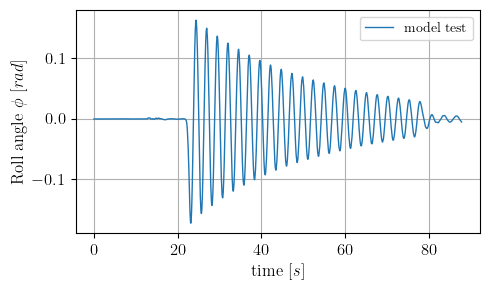

In [4]:
data = pd.read_csv('../../data/external/model_test_21340.csv', index_col=0)
fig,ax=plt.subplots()
data.plot(y='phi', ax=ax, label='model test');
ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)

The oscillating motion can be described by a spring-mass-damper system as seen in Fig.[(below)](#fig_spring_mass_damper).

<a id="fig_spring_mass_damper"></a>

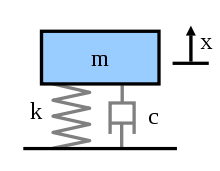

In [5]:
Image('../figures/220px-Mass_spring_damper.svg.png')

This system can me described as the following ordinary differential equation:

In [6]:
Equation(equations.roll_decay_equation_general_himeno, label='eq:roll_decay_equation_general_himeno')

<src.notebook_to_latex.Equation object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A cubic model can be obtained by using cubic damping:

In [7]:
Equation(equations.b44_cubic_equation, label='eq:b44_cubic_equation')

<src.notebook_to_latex.Equation object>

And cubic stiffness model:

In [8]:
Equation(equations.restoring_equation_cubic, label='eq:restoring_equation_cubic')

<src.notebook_to_latex.Equation object>

The total equation is then written:

In [9]:
Equation(equations.roll_decay_equation_quadratic_, label='eq:roll_decay_equation_quadratic', max_length=200)

<src.notebook_to_latex.Equation object>

This equation does not have one unique solution however. If all parameters would be  multiplied by a factor $k$ these parameters would also yield as a solution to the equation. All parameters are therefore divided by the total inertia $A_{44}$ (including added mass inertia), replacing the parameters with new normalized parameters such as: $B_{1A} = B_1/A_{44}$. The equation is now rewritten with these new parameters which have unique solutions:

<a id="eq_eq:roll_decay_equation_quadratic_A"></a>

In [10]:
Equation(equations.roll_decay_equation_quadratic_A, label='eq:roll_decay_equation_quadratic_A', max_length=200)

<src.notebook_to_latex.Equation object>

# Data
The data used in this study is described in Tab.[(below)](#tab_data_files). There is one result with a pure FNPF simulation at 0 knots. For model test results, two tests are available at 0 knots and one test at 15.5 knots. There is also a result at 15.5 with a hybrid method, where semi empirical viscosity has been injected into the FNPF calculations.

<a id="tab_data_files"></a>

In [11]:
content = pd.read_csv('../../data/external/content.csv', sep=';')
table_parameters = content.round(decimals=3)
content.set_index('file', inplace=True)

rename = {}
units = {
    'Ship speed' : r'$[kts]$',
}

table_parameters['data file'] = table_parameters['data file'].apply(lambda x : '\\text{%s}' % x)


lt = LateXTable(table_parameters, units=units, rename=rename, caption='Data files', label='data_files')
lt

file,data file,Ship speed,Method
,,$[kts]$,
1,\text{fnpf_kvlcc2_rolldecay_0kn.csv},0.0,FNPF
2,\text{model_test_21337.csv},0.0,model test
3,\text{model_test_21338.csv},0.0,model test
4,\text{model_test_21340.csv},15.5,model test
5,\text{fnpf_kvlcc2_rolldecay_15-5kn_ikeda_dev.csv},15.5,hybrid


Fig. [(below)](#fig_all_tests) shows the roll angle time series for all the tests. It can also be seen that test 1 and 5 also have time series for the roll angle velocity and acceleration from the conducted FNPF simulations. For the model test (2,3,4) velocities and accelerations were not measured during the tests. 

<a id="fig_all_tests">

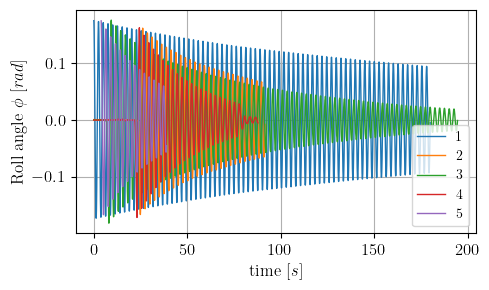

In [34]:
fig,ax=plt.subplots()
    
for file, row in content.iterrows():
    
    data = load(row['data file'])
    rolldecay.plot(data, y='phi', ax=ax, label=file);

ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)

<a id="fig_vel_acc"></a>

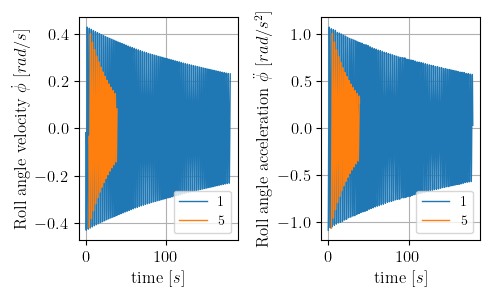

In [35]:
fig,axes=plt.subplots(ncols=2)
    
for file, row in content.iterrows():
    
    data = load(row['data file'])
    
    if 'phi1d' in data:
        rolldecay.plot(data, y='phi1d', ax=axes[0], label=file);
        
    if 'phi2d' in data:
        rolldecay.plot(data, y='phi2d', ax=axes[1], label=file);

        
axes[0].set_ylabel(r'Roll angle velocity $\dot\phi$ $[rad/s]$')
axes[0].set_xlabel(r'time $[s]$')
axes[0].grid(True)

axes[1].set_ylabel(r'Roll angle acceleration $\ddot\phi$ $[rad/s^2]$')
axes[1].set_xlabel(r'time $[s]$')
axes[1].grid(True)

# Analysis

## FNPF
The FNPF results have the benifit of having all the three states: $\phi$, $\dot{\phi}$ and $\ddot{\phi}$. This means that these time series can be inserted into the differential equation (Eq.[(see)](#eq_eq:roll_decay_equation_quadratic_A)) and the parameters of the model can be estimated using Ordinary Least Square method (OLS), solving the following regression:

In [36]:
 Equation(r'y = X \cdot \beta + \epsilon', label='ols')

<src.notebook_to_latex.Equation object>

where:
* $y$ is the dependent variable (also called *label*). 
* $\beta$ is a vector with the regressed parameters.
* $X$ is a matrix containing the independent variables (also called *features*).

The roll decay equation can be expressed as a linear regression with
* $y$ : the roll angle acceleration $\ddot{\phi}$ 
* $\beta$ : contains all the parameters : $B_1$, $B_2$, $C_1$...
* $X$ : contains all the time varying features such as: $| \dot{\phi} | \dot{\phi} $ etc.

In [178]:
acceleration_equation_cubic = sp.Eq(symbols.phi_dot_dot,
                                    sp.solve(equations.roll_decay_equation_cubic_A, symbols.phi_dot_dot)[0])
Equation(acceleration_equation_cubic, label='acceleration_equation_cubic')

<src.notebook_to_latex.Equation object>

In [180]:
y_,x_1,x_2,x_3,x_4,x_5,x_6 = sp.symbols('y x_1 x_2 x_3 x_4 x_5 x_6')

subs = {
    
    symbols.phi**5:x_6,
    symbols.phi**3:x_5,
    sp.Abs(symbols.phi_dot)*symbols.phi_dot:x_4,
    symbols.phi_dot**3:x_3,
    symbols.phi_dot:x_2,
    symbols.phi:x_1,
    
}

In [181]:
acceleration_equation_cubic_x = sp.Eq(y_,
                                      acceleration_equation_cubic.rhs.subs(subs))
Equation(acceleration_equation_cubic_x,'acceleration_equation_cubic_x')

<src.notebook_to_latex.Equation object>

In [182]:
xs = [x_1,x_2,x_3,x_4,x_5,x_6]

beta,X,epsilon = sp.symbols('beta X epsilon')
sp.Matrix(xs)

sp.linear_eq_to_matrix([acceleration_equation_cubic_x.rhs],xs)[0]



Matrix([[-C_1A, -B_1A, -B_3A, -B_2A, -C_3A, -C_5A]])

In [183]:
eq_X = sp.Eq(sp.Matrix(np.flipud(list(subs.values()))), 
             sp.Matrix(np.flipud(list(subs.keys()))))
eq_X

Eq(Matrix([
[x_1],
[x_2],
[x_3],
[x_4],
[x_5],
[x_6]]), Matrix([
[                                          phi(t)],
[                           Derivative(phi(t), t)],
[                        Derivative(phi(t), t)**3],
[Abs(Derivative(phi(t), t))*Derivative(phi(t), t)],
[                                       phi(t)**3],
[                                       phi(t)**5]]))

In [184]:
eq_y = sp.Eq(y_,symbols.phi_dot_dot)
Equation(eq_y,'eq_y')

<src.notebook_to_latex.Equation object>

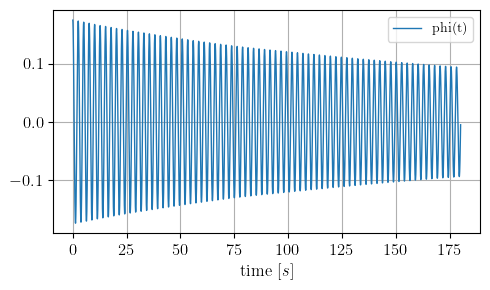

In [185]:
meta_data = content.loc[1]
data = load(meta_data['data file'])
renames = {
    'phi' : symbols.phi,
    'phi1d' : symbols.phi_dot,
    'phi2d' :symbols.phi_dot_dot,
}
data.rename(columns=renames, inplace=True)
rolldecay.plot(data,y=symbols.phi);

In [186]:
data.head()

,phi(t),"Derivative(phi(t), t)","Derivative(phi(t), (t, 2))",V1
Time,,,,
0.02,0.174388,-0.018087,-1.091653,3.082352e-11
0.04,0.173809,-0.039806,-1.082627,-3.701665e-05
0.06,0.172796,-0.061389,-1.074681,-7.304180e-05
0.08,0.171354,-0.082849,-1.065540,-1.121690e-04
0.10,0.169484,-0.104042,-1.056223,-1.409602e-04


In [187]:
X_lambda = sp.lambdify([symbols.phi,symbols.phi_dot,symbols.phi_dot_dot],eq_X.rhs)

In [188]:
X = X_lambda(data[symbols.phi], data[symbols.phi_dot], data[symbols.phi_dot_dot])
X = X.reshape(X.shape[0],X.shape[-1]).T
X = pd.DataFrame(data=X, index=data.index, columns=list(eq_X.lhs))
X.head()

,x_1,x_2,x_3,x_4,x_5,x_6
Time,,,,,,
0.02,0.174388,-0.018087,-0.000006,-0.000327,0.005303,0.000161
0.04,0.173809,-0.039806,-0.000063,-0.001584,0.005251,0.000159
0.06,0.172796,-0.061389,-0.000231,-0.003769,0.005159,0.000154
0.08,0.171354,-0.082849,-0.000569,-0.006864,0.005031,0.000148
0.10,0.169484,-0.104042,-0.001126,-0.010825,0.004868,0.000140


In [189]:
y = data[symbols.phi_dot_dot]

In [190]:
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Derivative(phi(t), (t, 2))   R-squared (uncentered):                   1.000
Model:                                    OLS   Adj. R-squared (uncentered):              1.000
Method:                         Least Squares   F-statistic:                          1.053e+08
Date:                        Fri, 28 May 2021   Prob (F-statistic):                        0.00
Time:                                18:02:32   Log-Likelihood:                          42714.
No. Observations:                        9000   AIC:                                 -8.542e+04
Df Residuals:                            8994   BIC:                                 -8.537e+04
Df Model:                                   6                                                  
Covariance Type:                    nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x_1           -6.1162      0.001  -6055.181      0.000      -6.118      -6.114
x_2           -0.0163      0.001    -16.878      0.000      -0.018      -0.014
x_3           -0.0981      0.013     -7.444      0.000      -0.124      -0.072
x_4            0.0617      0.007      8.508      0.000       0.047       0.076
x_5            5.5215      0.146     37.941      0.000       5.236       5.807
x_6         -254.0934      4.678    -54.312      0.000    -263.264    -244.923
==============================================================================
Omnibus:                      496.814   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1895.581
Skew:                           0.126   Prob(JB):                         0.00
Kurtosis:                       5.234   Cond. No.                     4.97e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

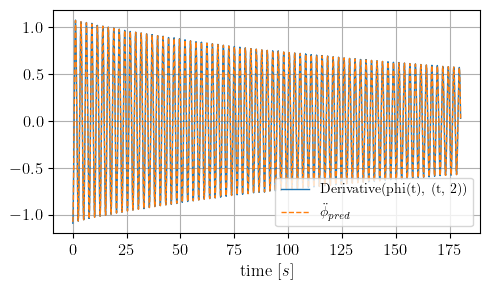

In [191]:
y_pred = results.predict(X)

fig,ax=plt.subplots()
rolldecay.plot(data, y=symbols.phi_dot_dot, ax=ax)

ax.plot(data.index, y_pred, '--', label=r'$\ddot{\phi}_{pred}$')

ax.legend();

In [192]:
X2 = X.drop(columns=[x_2,x_3,x_5,x_6])
model2 = sm.OLS(y,X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Derivative(phi(t), (t, 2))   R-squared (uncentered):                   1.000
Model:                                    OLS   Adj. R-squared (uncentered):              1.000
Method:                         Least Squares   F-statistic:                          1.750e+08
Date:                        Fri, 28 May 2021   Prob (F-statistic):                        0.00
Time:                                18:03:29   Log-Likelihood:                          40052.
No. Observations:                        9000   AIC:                                 -8.010e+04
Df Residuals:                            8998   BIC:                                 -8.009e+04
Df Model:                                   2                                                  
Covariance Type:                    nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x_1           -6.1007      0.000  -1.87e+04      0.000      -6.101      -6.100
x_4           -0.0233      0.000    -51.758      0.000      -0.024      -0.022
==============================================================================
Omnibus:                     1351.463   Durbin-Watson:                   0.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22529.876
Skew:                           0.024   Prob(JB):                         0.00
Kurtosis:                      10.751   Cond. No.                         1.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

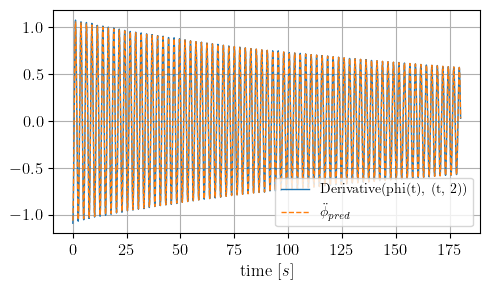

In [193]:
y_pred2 = results2.predict(X2)

fig,ax=plt.subplots()
rolldecay.plot(data, y=symbols.phi_dot_dot, ax=ax)

ax.plot(data.index, y_pred2, '--', label=r'$\ddot{\phi}_{pred}$')

ax.legend();

# Conclusions


# References
<div class="cite2c-biblio"></div>